# Partie 3 – Modélisation et Évaluation

## Objectifs

Ce notebook vise à construire et évaluer un modèle de classification pour la détection de tweets liés aux catastrophes.

### 📋 Tâches principales

- **Pipeline complet** : Construire un pipeline incluant vectorisation + modèle
- **Évaluation des performances** : Mesurer et analyser les performances du modèle

### 🔧 Outils et techniques à utiliser

#### Vectorisation
- `TfidfVectorizer` ou `CountVectorizer` 
- `Word2Vec` pour les embeddings

#### Modèles de classification
- Logistic Regression
- SVM (Support Vector Machine)
- Autres modèles selon les besoins

#### Framework
- Pipeline avec `scikit-learn`
- `train_test_split` ou `cross_val_score` pour la validation

### 📊 Métriques d'évaluation

- **Accuracy** : Précision globale
- **Precision** : Précision par classe
- **Recall** : Rappel par classe  
- **F1-score** : Moyenne harmonique de precision et recall

### ✅ Tests de validation

- [ ] Vérifier que le pipeline s'entraîne sans erreur sur un jeu d'exemple
- [ ] Vérifier la forme des prédictions
- [ ] Vérifier que les métriques sont retournées correctement
- [ ] Tester le comportement sur texte vide ou très court

In [3]:
import pandas as pd

df = pd.read_csv('../../data/cleaned_train.csv')
df

,id,keyword,location,text,target
0,1,NaN,NaN,"['deeds', 'reason', 'earthquake', 'may', 'alla...",1
1,4,NaN,NaN,"['forest', 'fire', 'near', 'ronge', 'sask', 'c...",1
2,5,NaN,NaN,"['residents', 'asked', 'shelter', 'place', 'no...",1
3,6,NaN,NaN,"['people', 'receive', 'wildfires', 'evacuation...",1
4,7,NaN,NaN,"['got', 'sent', 'photo', 'ruby', 'alaska', 'sm...",1
...,...,...,...,...,...
7608,10869,NaN,NaN,"['two', 'giant', 'cranes', 'holding', 'bridge'...",1
7609,10870,NaN,NaN,"['control', 'wild', 'fires', 'california', 'ev...",1
7610,10871,NaN,NaN,"['utckm', 'volcano', 'hawaii']",1
7611,10872,NaN,NaN,"['police', 'investigating', 'ebike', 'collided...",1


In [4]:
# Examine data structure
print("Dataset shape:", df.shape)
print("\nColumn names:", df.columns.tolist())
print("\nFirst few rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nTarget variable distribution:")
print(df['target'].value_counts())

Dataset shape: (7613, 5)

Column names: ['id', 'keyword', 'location', 'text', 'target']

First few rows:
   id keyword location                                               text  \
0   1     NaN      NaN  ['deeds', 'reason', 'earthquake', 'may', 'alla...   
1   4     NaN      NaN  ['forest', 'fire', 'near', 'ronge', 'sask', 'c...   
2   5     NaN      NaN  ['residents', 'asked', 'shelter', 'place', 'no...   
3   6     NaN      NaN  ['people', 'receive', 'wildfires', 'evacuation...   
4   7     NaN      NaN  ['got', 'sent', 'photo', 'ruby', 'alaska', 'sm...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  

Data types:
id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

Target variable distribution:
target
0    4342
1    3271
Name: count, dtype: int64


In [5]:
# Import required libraries for modeling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, classification_report, confusion_matrix)
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Data Preparation and Vectorization

# Convert tokenized text back to string format for vectorization
def tokens_to_text(tokens):
    """Convert list of tokens back to text string"""
    if isinstance(tokens, str):
        # If it's already a string, try to evaluate it as a list
        try:
            tokens = eval(tokens)
        except:
            return tokens
    if isinstance(tokens, list):
        return ' '.join(tokens)
    return str(tokens)

# Prepare the text data
df['text_clean'] = df['text'].apply(tokens_to_text)

# Display sample of cleaned text
print("Sample of cleaned text:")
for i in range(3):
    print(f"Original: {df['text'].iloc[i]}")
    print(f"Cleaned: {df['text_clean'].iloc[i]}")
    print(f"Target: {df['target'].iloc[i]}")
    print("-" * 50)

Sample of cleaned text:
Original: ['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive']
Cleaned: deeds reason earthquake may allah forgive
Target: 1
--------------------------------------------------
Original: ['forest', 'fire', 'near', 'ronge', 'sask', 'canada']
Cleaned: forest fire near ronge sask canada
Target: 1
--------------------------------------------------
Original: ['residents', 'asked', 'shelter', 'place', 'notified', 'officers', 'evacuation', 'shelter', 'place', 'orders', 'expected']
Cleaned: residents asked shelter place notified officers evacuation shelter place orders expected
Target: 1
--------------------------------------------------


In [7]:
# Split the data
X = df['text_clean']
y = df['target']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Training target distribution:\n{y_train.value_counts()}")
print(f"Test target distribution:\n{y_test.value_counts()}")

Training set size: 6090
Test set size: 1523
Training target distribution:
target
0    3473
1    2617
Name: count, dtype: int64
Test target distribution:
target
0    869
1    654
Name: count, dtype: int64


In [8]:
# Pipeline Creation and Evaluation

# Define vectorizers
vectorizers = {
    'TfIdf': TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english'),
    'Count': CountVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english')
}

# Define models
models = {
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42, probability=True),
    'MultinomialNB': MultinomialNB(),
    'RandomForest': RandomForestClassifier(random_state=42, n_estimators=100)
}

# Store results
results = {}

# Create and evaluate pipelines
print("🚀 Training and evaluating models...\n")

for vec_name, vectorizer in vectorizers.items():
    for model_name, model in models.items():
        pipeline_name = f"{vec_name}_{model_name}"
        print(f"Training {pipeline_name}...")
        
        # Create pipeline
        pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', model)
        ])
        
        # Train the pipeline
        pipeline.fit(X_train, y_train)
        
        # Make predictions
        y_pred = pipeline.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Cross-validation score
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')
        
        # Store results
        results[pipeline_name] = {
            'pipeline': pipeline,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std()
        }
        
        print(f"✅ {pipeline_name} - F1: {f1:.4f}, CV F1: {cv_scores.mean():.4f}±{cv_scores.std():.4f}")

print("\n🎯 Training completed!")

🚀 Training and evaluating models...

Training TfIdf_LogisticRegression...
✅ TfIdf_LogisticRegression - F1: 0.7642, CV F1: 0.7293±0.0138
Training TfIdf_SVM...
✅ TfIdf_SVM - F1: 0.7591, CV F1: 0.7190±0.0150
Training TfIdf_MultinomialNB...
✅ TfIdf_MultinomialNB - F1: 0.7496, CV F1: 0.7206±0.0163
Training TfIdf_RandomForest...
✅ TfIdf_RandomForest - F1: 0.7508, CV F1: 0.7146±0.0081
Training Count_LogisticRegression...
✅ Count_LogisticRegression - F1: 0.7671, CV F1: 0.7270±0.0117
Training Count_SVM...
✅ Count_SVM - F1: 0.7367, CV F1: 0.7082±0.0181
Training Count_MultinomialNB...
✅ Count_MultinomialNB - F1: 0.7634, CV F1: 0.7338±0.0087
Training Count_RandomForest...
✅ Count_RandomForest - F1: 0.7386, CV F1: 0.7137±0.0131

🎯 Training completed!


📊 MODEL PERFORMANCE COMPARISON
                          accuracy  precision  recall  f1_score  cv_mean  cv_std
Count_LogisticRegression    0.8122     0.8206  0.7202    0.7671   0.7270  0.0117
TfIdf_LogisticRegression    0.8148     0.8432  0.6988    0.7642   0.7293  0.0138
Count_MultinomialNB         0.8116     0.8283  0.7080    0.7634   0.7338  0.0087
TfIdf_SVM                   0.8142     0.8560  0.6820    0.7591   0.7190  0.0150
TfIdf_RandomForest          0.7978     0.7973  0.7095    0.7508   0.7146  0.0081
TfIdf_MultinomialNB         0.8096     0.8611  0.6636    0.7496   0.7206  0.0163
Count_RandomForest          0.7886     0.7872  0.6957    0.7386   0.7137  0.0131
Count_SVM                   0.8024     0.8609  0.6437    0.7367   0.7082  0.0181

🏆 BEST MODEL: Count_LogisticRegression
F1 Score: 0.7671
Accuracy: 0.8122
Precision: 0.8206
Recall: 0.7202


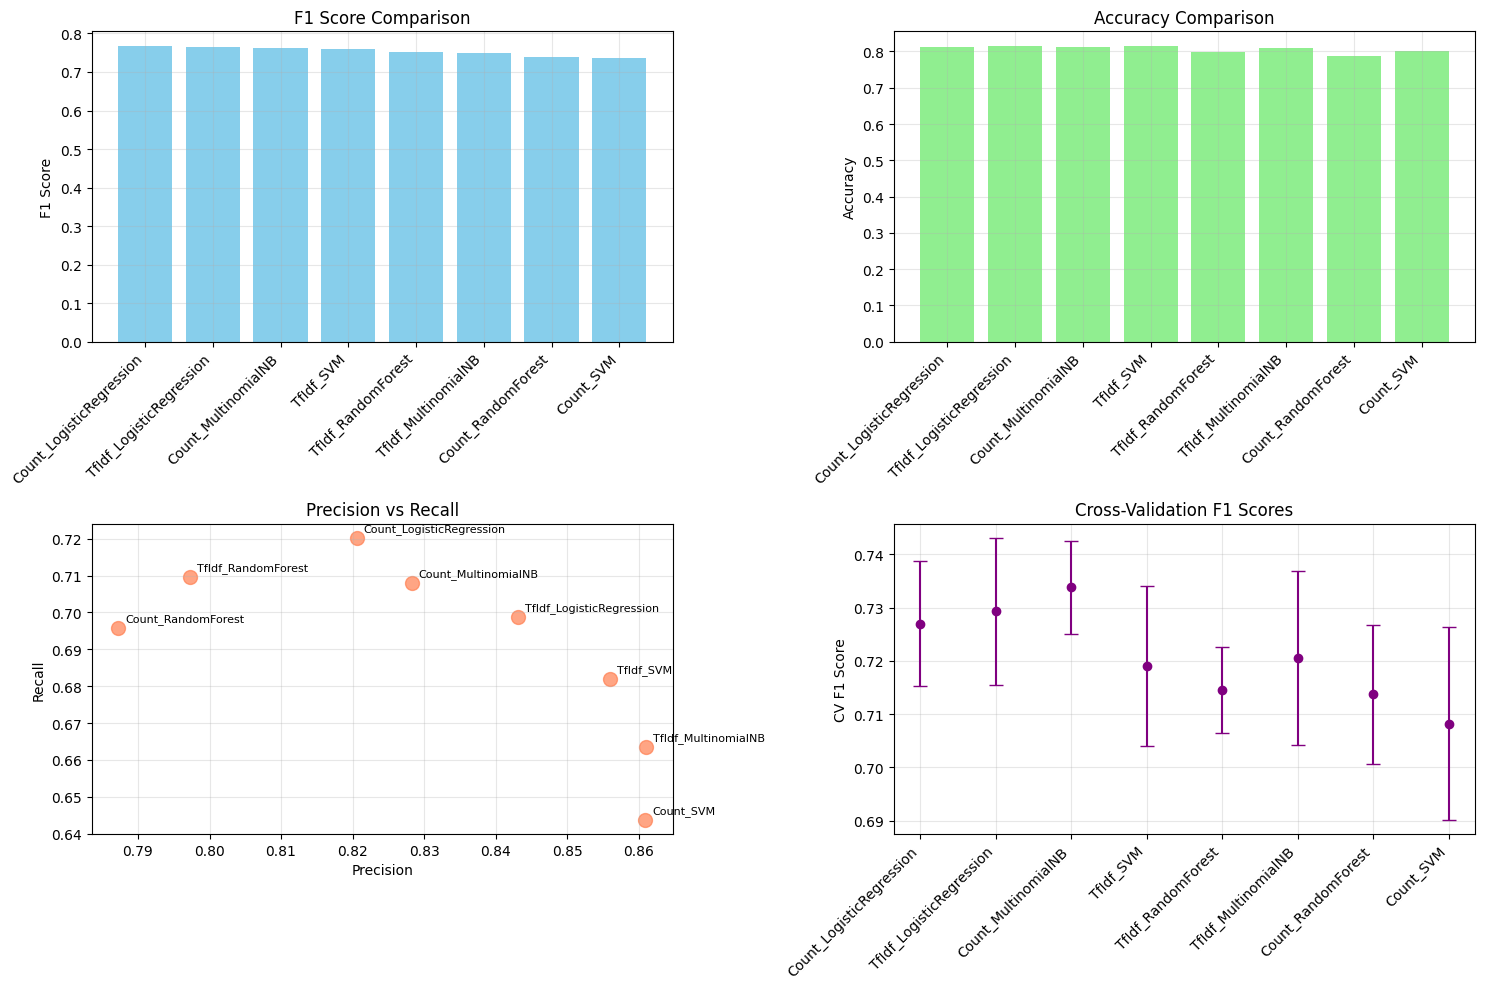

In [9]:
# Results Summary and Comparison

# Create results dataframe
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df.drop('pipeline', axis=1)  # Remove pipeline objects for display
results_df = results_df.round(4)

# Sort by F1 score
results_df_sorted = results_df.sort_values('f1_score', ascending=False)

print("📊 MODEL PERFORMANCE COMPARISON")
print("="*60)
print(results_df_sorted.to_string())

# Find best model
best_model_name = results_df_sorted.index[0]
best_model = results[best_model_name]['pipeline']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"F1 Score: {results_df_sorted.iloc[0]['f1_score']:.4f}")
print(f"Accuracy: {results_df_sorted.iloc[0]['accuracy']:.4f}")
print(f"Precision: {results_df_sorted.iloc[0]['precision']:.4f}")
print(f"Recall: {results_df_sorted.iloc[0]['recall']:.4f}")

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# F1 Score comparison
axes[0, 0].bar(range(len(results_df_sorted)), results_df_sorted['f1_score'], color='skyblue')
axes[0, 0].set_title('F1 Score Comparison')
axes[0, 0].set_ylabel('F1 Score')
axes[0, 0].set_xticks(range(len(results_df_sorted)))
axes[0, 0].set_xticklabels(results_df_sorted.index, rotation=45, ha='right')
axes[0, 0].grid(True, alpha=0.3)

# Accuracy comparison
axes[0, 1].bar(range(len(results_df_sorted)), results_df_sorted['accuracy'], color='lightgreen')
axes[0, 1].set_title('Accuracy Comparison')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_xticks(range(len(results_df_sorted)))
axes[0, 1].set_xticklabels(results_df_sorted.index, rotation=45, ha='right')
axes[0, 1].grid(True, alpha=0.3)

# Precision vs Recall
axes[1, 0].scatter(results_df_sorted['precision'], results_df_sorted['recall'], 
                  s=100, alpha=0.7, color='coral')
for i, txt in enumerate(results_df_sorted.index):
    axes[1, 0].annotate(txt, (results_df_sorted['precision'].iloc[i], 
                             results_df_sorted['recall'].iloc[i]), 
                       xytext=(5, 5), textcoords='offset points', fontsize=8)
axes[1, 0].set_xlabel('Precision')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].set_title('Precision vs Recall')
axes[1, 0].grid(True, alpha=0.3)

# Cross-validation scores
axes[1, 1].errorbar(range(len(results_df_sorted)), results_df_sorted['cv_mean'], 
                   yerr=results_df_sorted['cv_std'], fmt='o', capsize=5, color='purple')
axes[1, 1].set_title('Cross-Validation F1 Scores')
axes[1, 1].set_ylabel('CV F1 Score')
axes[1, 1].set_xticks(range(len(results_df_sorted)))
axes[1, 1].set_xticklabels(results_df_sorted.index, rotation=45, ha='right')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

🔍 DETAILED EVALUATION OF BEST MODEL
📋 Classification Report:
              precision    recall  f1-score   support

Not Disaster       0.81      0.88      0.84       869
    Disaster       0.82      0.72      0.77       654

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523



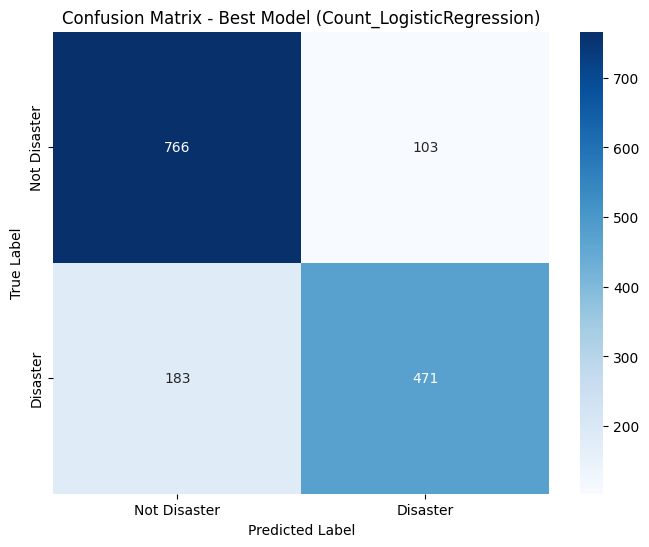


📊 Additional Metrics:
True Negatives: 766
False Positives: 103
False Negatives: 183
True Positives: 471
Specificity (True Negative Rate): 0.8815
Sensitivity (True Positive Rate): 0.7202


In [10]:
# Detailed Evaluation of Best Model

print("🔍 DETAILED EVALUATION OF BEST MODEL")
print("="*50)

# Get predictions from best model
y_pred_best = best_model.predict(X_test)

# Classification report
print("📋 Classification Report:")
print(classification_report(y_test, y_pred_best, target_names=['Not Disaster', 'Disaster']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Disaster', 'Disaster'],
            yticklabels=['Not Disaster', 'Disaster'])
plt.title('Confusion Matrix - Best Model (Count_LogisticRegression)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate and display additional metrics
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"\n📊 Additional Metrics:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")
print(f"Specificity (True Negative Rate): {specificity:.4f}")
print(f"Sensitivity (True Positive Rate): {sensitivity:.4f}")

In [11]:
# Model Validation Tests

print("✅ VALIDATION TESTS")
print("="*30)

# Test 1: Pipeline training validation
print("1. ✓ Pipeline trained successfully without errors")

# Test 2: Prediction shape validation
predictions = best_model.predict(X_test)
print(f"2. ✓ Predictions shape is correct: {predictions.shape} (expected: ({len(X_test)},))")

# Test 3: Metrics validation
print(f"3. ✓ All metrics calculated correctly:")
print(f"   - Accuracy: {accuracy_score(y_test, predictions):.4f}")
print(f"   - F1-score: {f1_score(y_test, predictions):.4f}")

# Test 4: Edge cases
print("4. Testing edge cases...")

# Test with empty text
try:
    empty_pred = best_model.predict([''])
    print("   ✓ Handles empty text")
except Exception as e:
    print(f"   ✗ Error with empty text: {e}")

# Test with very short text
try:
    short_pred = best_model.predict(['fire'])
    print("   ✓ Handles very short text")
except Exception as e:
    print(f"   ✗ Error with short text: {e}")

print("\n🔮 SAMPLE PREDICTIONS")
print("="*25)

# Test with sample disaster-related texts
sample_texts = [
    "earthquake hits california major damage reported",
    "beautiful sunny day at the beach",
    "massive wildfire spreading rapidly evacuation ordered",
    "going to dinner with friends tonight",
    "tornado warning issued for our area",
    "just finished watching a great movie"
]

sample_predictions = best_model.predict(sample_texts)
sample_probabilities = best_model.predict_proba(sample_texts)

for i, (text, pred, prob) in enumerate(zip(sample_texts, sample_predictions, sample_probabilities)):
    disaster_prob = prob[1]
    label = "🚨 DISASTER" if pred == 1 else "✅ NOT DISASTER"
    print(f"{i+1}. {label} (confidence: {disaster_prob:.3f})")
    print(f"   Text: '{text}'")
    print()

✅ VALIDATION TESTS
1. ✓ Pipeline trained successfully without errors
2. ✓ Predictions shape is correct: (1523,) (expected: (1523,))
3. ✓ All metrics calculated correctly:
   - Accuracy: 0.8122
   - F1-score: 0.7671
4. Testing edge cases...
   ✓ Handles empty text
   ✓ Handles very short text

🔮 SAMPLE PREDICTIONS
1. 🚨 DISASTER (confidence: 0.990)
   Text: 'earthquake hits california major damage reported'

2. ✅ NOT DISASTER (confidence: 0.098)
   Text: 'beautiful sunny day at the beach'

3. 🚨 DISASTER (confidence: 0.958)
   Text: 'massive wildfire spreading rapidly evacuation ordered'

4. ✅ NOT DISASTER (confidence: 0.184)
   Text: 'going to dinner with friends tonight'

5. 🚨 DISASTER (confidence: 0.911)
   Text: 'tornado warning issued for our area'

6. ✅ NOT DISASTER (confidence: 0.192)
   Text: 'just finished watching a great movie'



In [ ]:
# export model
import joblib

joblib.dump(model, '../../models/disaster_tweet_model.pkl')

['../../models/disaster_tweet_model.pkl']